In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/Classification/heart.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0, index_col=None)
dataset.head()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


 - __Replicate Feature Selection methods and create train and test sets for each method separately__

In [5]:
sex_dummy = pd.get_dummies(dataset.sex)
sex_dummy.columns = ["Male", "Female"]

cp_dummy = pd.get_dummies(dataset.cp)
cp_dummy.columns = ["cp0", "cp1", "cp2", "cp3"]

fbs_dummy = pd.get_dummies(dataset.fbs)
fbs_dummy.columns = ["fbs0", "fbs1"]

restecg_dummy = pd.get_dummies(dataset.restecg)
restecg_dummy.columns = ["restecg0", "restecg1", "restecg2"]

exang_dummy = pd.get_dummies(dataset.exang)
exang_dummy.columns = ["exang0", "exang1"]

slope_dummy = pd.get_dummies(dataset.slope)
slope_dummy.columns = ["slope0", "slope1", "slope2"]

ca_dummy = pd.get_dummies(dataset.ca)
ca_dummy.columns = ["ca0", "ca1", "ca2", "ca3", "ca4"]

thal_dummy = pd.get_dummies(dataset.thal)
thal_dummy.columns = ["thal0", "thal1", "thal2", "thal3"]

tmp = dataset[["target", "age", "trestbps", "chol", "thalach", "oldpeak"]]

onehot_data = pd.concat([tmp, sex_dummy, cp_dummy, fbs_dummy, restecg_dummy, exang_dummy, slope_dummy, ca_dummy, thal_dummy],
                       axis=1)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, chi2, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [7]:
X = onehot_data.drop('target', axis=1)
y = onehot_data['target']
X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(242, 30) (61, 30) (242,) (61,)


In [8]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi, index=X_train.columns)
mi.sort_values(ascending=False, inplace=True)

sel = SelectKBest(mutual_info_classif, 10).fit(X_train, y_train)

train_copy = X_train
test_copy = X_test
train_copy.columns[sel.get_support()]
test_copy.columns[sel.get_support()]

X_train_mi = sel.transform(train_copy)
X_test_mi = sel.transform(test_copy)

del train_copy, test_copy
X_train_mi.shape, X_test_mi.shape

((242, 10), (61, 10))

In [9]:
f_score = chi2(X_train, y_train)
p_values = pd.Series(f_score[1], index=X_train.columns)
p_values.sort_values(ascending=False, inplace=True)

sel = SelectKBest(chi2, 10).fit(X_train, y_train)

train_copy = X_train
test_copy = X_test
train_copy.columns[sel.get_support()]
test_copy.columns[sel.get_support()]

X_train_chi = sel.transform(train_copy)
X_test_chi = sel.transform(test_copy)

X_train_chi.shape, X_test_chi.shape

((242, 10), (61, 10))

In [20]:
anova_f = f_classif(X_train, y_train)
p_values = pd.Series(anova_f[1], index=X_train.columns)
p_values.sort_values(ascending=False, inplace=True)

sel = SelectKBest(f_classif, 10).fit(X_train, y_train)

train_copy = X_train
test_copy = X_test
train_copy.columns[sel.get_support()]
test_copy.columns[sel.get_support()]

X_train_f = sel.transform(train_copy)
X_test_f = sel.transform(test_copy)

del train_copy, test_copy

X_train_f.shape, X_test_f.shape

((242, 10), (61, 10))

In [22]:
del X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          k_features=(1, X_train.shape[1]), 
          forward=True, 
          floating=False, 
          verbose=2, 
          scoring='accuracy', 
          cv = 4, 
          n_jobs=-1).fit(X_train, y_train)

X_train[list(sfs.k_feature_names_)]
X_test[list(sfs.k_feature_names_)]

X_train_sfsF = sfs.transform(X_train)
X_test_sfsF = sfs.transform(X_test)

X_train_sfsF.shape, X_test_sfsF.shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.4s finished

[2020-05-14 11:32:50] Features: 1/30 -- score: 0.76051912568306[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   19.4s finished

[2020-05-14 11:33:10] Features: 2/30 -- score: 0.7645491803278688[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   17.7s finished

[2020-05-14 11:33:28] Features: 3/30 -- score: 0.7810109289617486[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   17.0s finished

[2020-05-14 11:33:45] Features: 4/30 -- score: 0.8345628415300547[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   16.9s finished

[2

((242, 16), (61, 16))

In [24]:
del X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          k_features=(1, X_train.shape[1]), 
          forward=False, 
          floating=False, 
          verbose=2, 
          scoring='accuracy', 
          cv = 4, 
          n_jobs=-1).fit(X_train, y_train)

X_train[list(sfs.k_feature_names_)]
X_test[list(sfs.k_feature_names_)]

X_train_sfsB = sfs.transform(X_train)
X_test_sfsB = sfs.transform(X_test)

X_train_sfsB.shape, X_test_sfsB.shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.6s finished

[2020-05-14 11:40:21] Features: 29/1 -- score: 0.8468579234972677[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   19.5s finished

[2020-05-14 11:40:40] Features: 28/1 -- score: 0.8469262295081967[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   17.5s finished

[2020-05-14 11:40:58] Features: 27/1 -- score: 0.8551912568306012[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   17.3s finished

[2020-05-14 11:41:15] Features: 26/1 -- score: 0.8511612021857924[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   17.1s finished



((242, 16), (61, 16))

In [26]:
del X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

rfe = RFECV(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), 
          step=1, 
          cv=StratifiedKFold(10),
          scoring='accuracy', 
          n_jobs=-1).fit(X_train, y_train)

train_copy = X_train
test_copy = X_test

train_copy.drop(train_copy.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test_copy.drop(test_copy.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

X_train_rfe = pd.DataFrame(train_copy)
X_test_rfe = pd.DataFrame(test_copy)
X_train_rfe.shape, X_test_rfe.shape

((242, 26), (61, 26))

 - __Import required modules__

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, confusion_matrix

# Build Decision Tree Classifier

In [14]:
train_size = np.linspace(0.1, 1.0, 10)
def build_classifier(X_train_data, y_train_data, X_test_data, y_test_data, text="ABC"):
    
    model = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0)
    train_sizes, train_scores, validation_scores = learning_curve(estimator = model,
                                                                  X = X_train_data,
                                                                  y = y_train_data,
                                                                  train_sizes = train_size,
                                                                  cv = StratifiedKFold(10),
                                                                  scoring = 'accuracy',
                                                                  shuffle = True,
                                                                  random_state=1)

    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    
    model.fit(X_train_data, y_train_data)
    y_pred = model.predict(X_test_data)
    acc = round(accuracy_score(y_test_data, y_pred),3)
    rec = round(recall_score(y_test_data, y_pred),3)
    
    print("The accuracy score for the model is: {}".format(acc))
    print("The recall score for the model is: {}".format(rec))
    
    fig = plt.figure(figsize=(12,5))
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('Accuracy', fontsize = 12)
    plt.xlabel('Training set size', fontsize = 12)
    plt.title('Learning curves for a Decision Tree model & FE Method:  ' + text, fontsize = 14, y = 1.03)
    plt.legend()
    plt.grid()
    plt.show()

    met = confusion_matrix(y_test_data, y_pred)
    sns.heatmap(met, square=True, annot=True, fmt="d", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

# Run Classifier without any Feature Selection

The accuracy score for the model is: 0.803
The recall score for the model is: 0.848


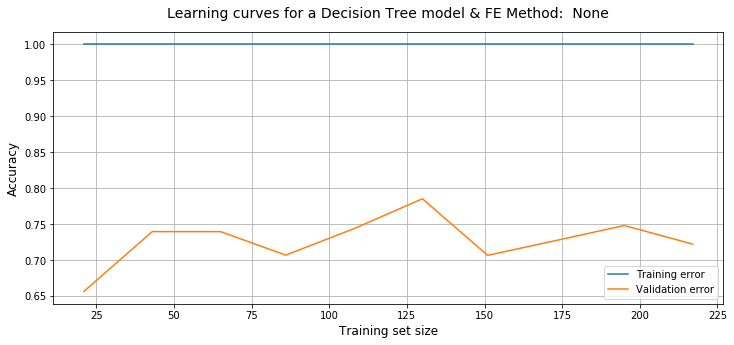

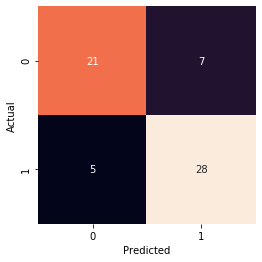

In [15]:
build_classifier(X_train, y_train, X_test, y_test, text="None")

# Run Classifier on Mutual Information

The accuracy score for the model is: 0.754
The recall score for the model is: 0.758


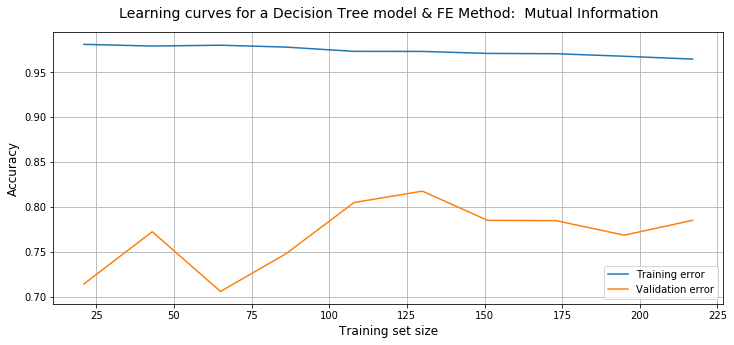

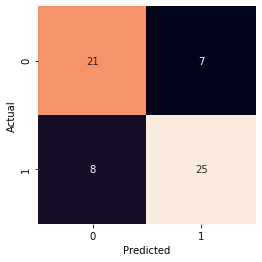

In [18]:
build_classifier(X_train_mi, y_train, X_test_mi, y_test, text="Mutual Information")

# Run Classifier on Chi Square

The accuracy score for the model is: 0.738
The recall score for the model is: 0.788


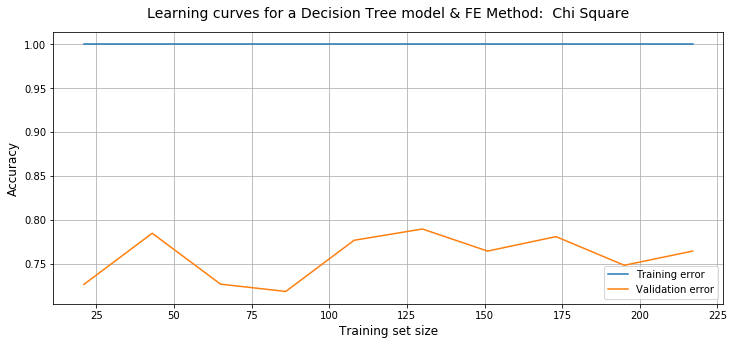

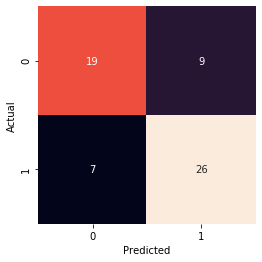

In [19]:
build_classifier(X_train_chi, y_train, X_test_chi, y_test, text="Chi Square")

# Run Classifier on Anova Fischer Score

The accuracy score for the model is: 0.738
The recall score for the model is: 0.788


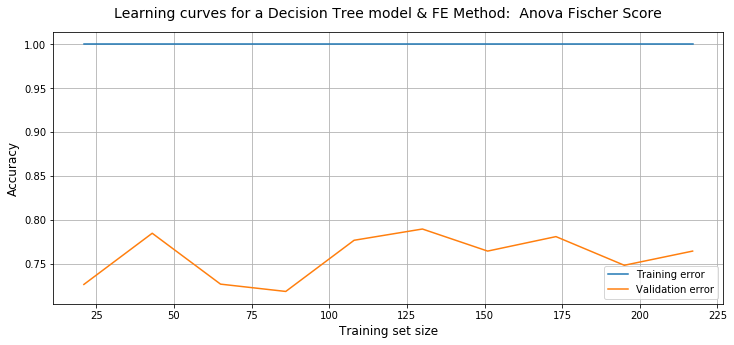

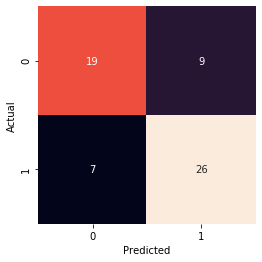

In [21]:
build_classifier(X_train_f, y_train, X_test_f, y_test, text="Anova Fischer Score")

# Run Classifier on SFS Forward

The accuracy score for the model is: 0.738
The recall score for the model is: 0.727


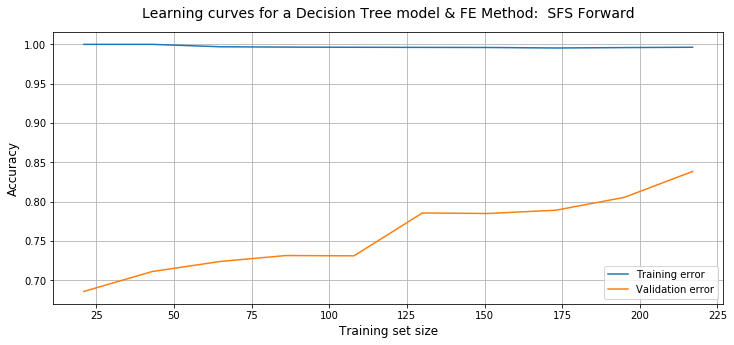

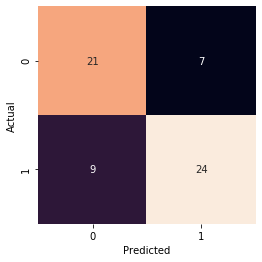

In [23]:
build_classifier(X_train_sfsF, y_train, X_test_sfsF, y_test, text="SFS Forward")

# Run Classifier on SFS Backward

The accuracy score for the model is: 0.738
The recall score for the model is: 0.788


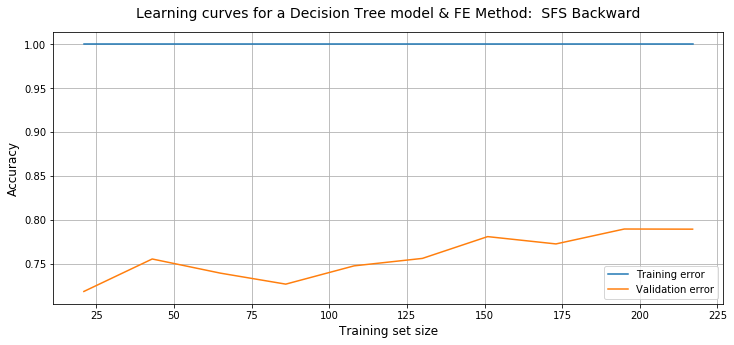

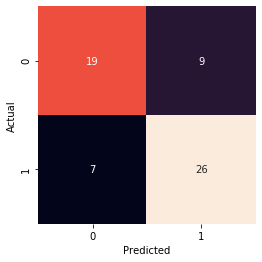

In [25]:
build_classifier(X_train_sfsB, y_train, X_test_sfsB, y_test, text="SFS Backward")

# Run Classifier on RFE

The accuracy score for the model is: 0.787
The recall score for the model is: 0.818


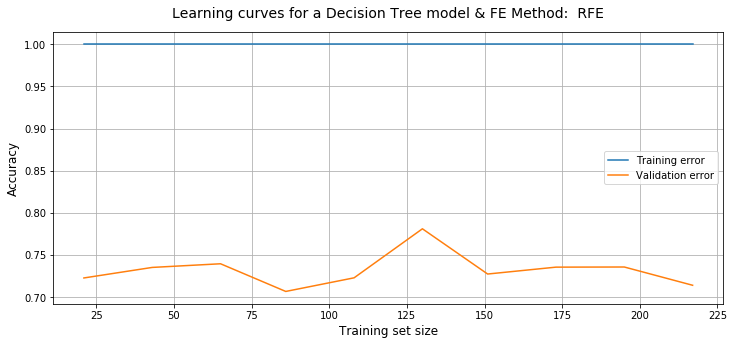

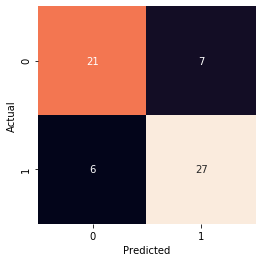

In [27]:
build_classifier(X_train_rfe, y_train, X_test_rfe, y_test, text="RFE")

 - __Useful links__:-
         - https://www.dataquest.io/blog/learning-curves-machine-learning/
         - https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
         - https://www.ritchieng.com/machinelearning-learning-curve/